In [ ]:
!pip install py-rouge
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

sns.set(style="darkgrid")

df = pd.read_csv('/content/drive/MyDrive/NLP Summarization Project/Generated Summaries/1f BART_finetuned on optimal hp_beam2.csv')

# the original test data contains the reference rouge 2 score needed here
test = pd.read_csv('/content/drive/MyDrive/1 Input Data/2 test.csv')
df = df.merge(test[['original_row_idx', 'reference_rouge2']], on = 'original_row_idx', how = 'left')

df.head(2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,original_row_idx,article,summary,source,category,generated,rouge1f,rouge2f,rougeLf,rouge1r,rouge2r,rougeLr,rouge1p,rouge2p,rougeLp,reference_rouge2
0,404718,Enterprise treats the crowd at John F. Kennedy...,Check out these eight pictures of Space Shuttl...,mashable,unparsable,The Space Shuttle Enterprise arrived at New Yo...,0.400000,0.323529,0.415342,0.700000,0.578947,0.653320,0.280000,0.224490,0.304445,0.075472
1,513863,Mickelson’s comments set off a chain of events...,"Mickelson, a member of eight losing teams, was...",nytimes,sports,"Phil Mickelson, who has been named vice captai...",0.197183,0.028986,0.196729,0.291667,0.043478,0.270582,0.148936,0.021739,0.154547,0.064935


In [ ]:
# add several metrics of interest
df['article_length'] = df['article'].apply(lambda x: len(word_tokenize(x)))
df['summary_length'] = df['summary'].apply(lambda x: len(word_tokenize(x)))

df['article_summary_ratio'] = df['article_length']/df['summary_length']

df['source-category'] = df[['source', 'category']].apply(lambda x: '-'.join([str(i) for i in x]), axis = 1)

## Potential factors to BART performance

We use the ROUGE-2 Recall score of BART generated summaries (evaluated against the reference summary) as an approximation of the model's performance. Additionally, the reference summary's ROUGE-2 Recall score (evaluated against the first 100 words of the article) is used as a proxy for how "head-heavy" the news article is.

Head-heaviness is the only factor highly correlated to BART performance. Article length, reference summary length and article/ref summary length ratio has very little correlation to BART performance.

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

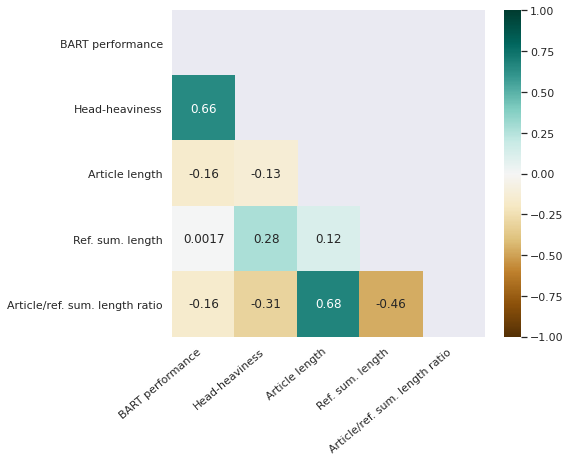

In [98]:
corr_df = df[['rouge2r', 'reference_rouge2', 'article_length', 'summary_length', 'article_summary_ratio']]
corr_df.columns = ['BART performance', 'Head-heaviness', 'Article length', 'Ref. sum. length', 'Article/ref. sum. length ratio']

plt.figure(figsize=(7, 6))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr_df.corr(), dtype=np.bool))

heatmap = sns.heatmap(corr_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

plt.xticks(rotation=40, ha = 'right')

## Effect of head-heaviness

We isolate records where ROUGE-2R score is above 75th percentile (high performance) or below 25th percentile (low performance).

Density estimation of the high/low model performance group shows large disparity in head heaviness. Low performing records tends to have very low head-heaviness, implying the key information for these types of articles are scattered throughout the article rather than concentrated in the beginning passage.

In [72]:
# create a new column to indicate whether the rouge2r score is above q3 (high) or below q1 (low)
df['below q1'] = (df['rouge2r'] < float(df['rouge2r'].quantile([0.25]))).astype(str)
df['above q3'] = (df['rouge2r'] > float(df['rouge2r'].quantile([0.75]))).astype(str)
df['BART performance'] = df[['below q1', 'above q3']].apply(lambda x: ' '.join(x), axis = 1)\
  .replace({'False True': 'High', 'True False': 'Low'})

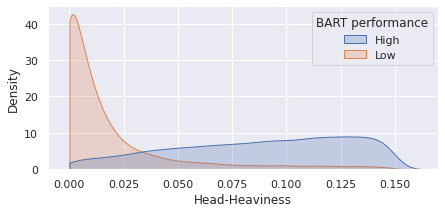

In [110]:
f, ax = plt.subplots(figsize=(7, 3))

sns.kdeplot( data = df[df['BART performance'].isin(['Low', 'High'])], x = 'reference_rouge2', hue = 'BART performance', fill = True, common_norm=False, clip = (0,1), ax = ax)

ax.set(xlabel = "Head-Heaviness", xlim = (-0.01, 0.17))
plt.show()

## News Source Writing Style

We filtered for only news sources that have more than 1000 records in the test set to avoid small samples that might cause sampling error.

The news sources that have good BART performance also have high head-heaviness, as expected.

In [5]:
# create a dataframe with news sources that have more than 1000 records
source_count = df.groupby('source').count().rename(columns = {'article': 'count'})[['count']].reset_index()
source_count = source_count[source_count['count'] > 1000]

source_means = df.groupby('source').mean()[['rouge2r', 'reference_rouge2', 'article_length', 'summary_length', 'article_summary_ratio']].reset_index()

source_stats = source_count.merge(source_means, on = 'source', how = 'left').sort_values('rouge2r', ascending = False).set_index('source')

source_stats

,count,rouge2r,reference_rouge2,article_length,summary_length,article_summary_ratio
source,,,,,,
nydailynews,5427,0.493769,0.084311,481.539340,24.196425,21.980972
foxnews,5572,0.440424,0.068625,538.263999,21.524228,30.284107
9news,2477,0.389500,0.068498,346.427130,23.643117,15.127826
usatoday,4405,0.373281,0.048769,528.026561,20.821793,27.421933
cbc,1144,0.349529,0.072145,572.854021,29.694056,21.640876
mashable,3643,0.348792,0.057602,438.364260,20.922042,23.337123
latimes,1019,0.327378,0.059430,505.806673,26.541708,23.607795
bostonglobe,1462,0.296606,0.058076,616.829001,26.229822,27.757399
cnn,3438,0.278269,0.047282,633.044212,26.770797,26.920379


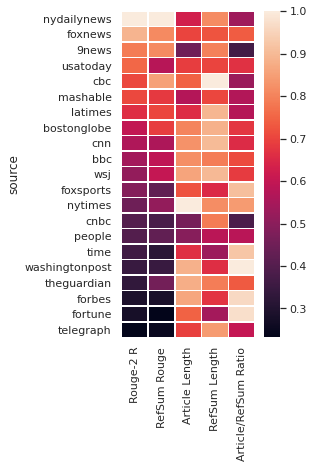

In [ ]:
for_heatmap = source_stats.div(source_stats.max(axis=0), axis=1)\
  [['rouge2r', 'reference_rouge2', 'article_length', 'summary_length', 'article_summary_ratio']]

for_heatmap.columns = ['Rouge-2 R', 'RefSum Rouge', 'Article Length', 'RefSum Length', 'Article/RefSum Ratio']

f, ax = plt.subplots(figsize=(3, 6))

ax = sns.heatmap(for_heatmap, linewidths=.5 , yticklabels = 1, ax = ax)

## News Category Writing Style

We filtered for only news categories that have more than 500 records in the test set to avoid small samples that might cause sampling error.

The news categories that have good BART performance also have high head-heaviness, as expected. Note that the least head-heavy categories tend to be types of writing that cannot be succinctly captured, such as opinions, which tend to be expositions.

In [ ]:
# create a dataframe with news categorys that have more than 1000 records
category_count = df.groupby('source-category').count().rename(columns = {'article': 'count'})[['count']].reset_index()
category_count = category_count[(category_count['count'] > 500) & (~category_count['source-category'].str.contains('PLACEHOLDER|unparsable'))]

category_means = df.groupby('source-category').mean()[['rouge2r', 'reference_rouge2', 'article_length', 'summary_length', 'article_summary_ratio']].reset_index()

category_stats = category_count.merge(category_means, on = 'source-category', how = 'left').sort_values('rouge2r', ascending = False).set_index('source-category')
category_stats

,count,rouge2r,reference_rouge2,article_length,summary_length,article_summary_ratio
source-category,,,,,,
nydailynews-entertainment,1012,0.542720,0.085133,455.958498,22.563241,22.426936
nydailynews-newyork,834,0.540190,0.088938,449.633094,23.954436,20.092649
nydailynews-news,2146,0.523855,0.089800,444.169618,23.800093,20.251826
foxnews-entertainment,833,0.520107,0.063698,442.618247,17.490996,29.670970
foxnews-us,810,0.489139,0.082806,462.640741,24.787654,20.277215
foxnews-politics,666,0.444820,0.079903,630.115616,25.318318,29.297696
usatoday-communities,1771,0.435890,0.040189,361.579898,20.429136,19.572222
9news-world,845,0.401417,0.071142,398.262722,23.811834,17.329035
nydailynews-sports,628,0.384249,0.073621,635.275478,27.831210,26.652165


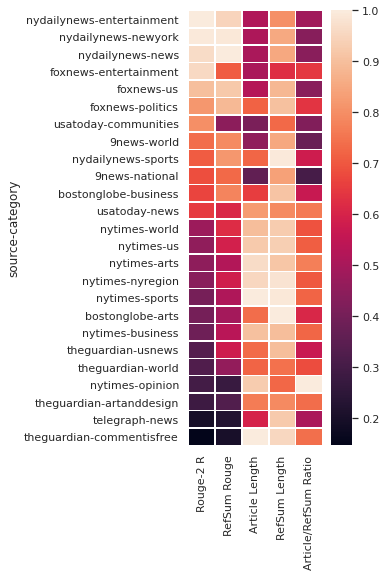

In [ ]:
for_heatmap = category_stats.div(category_stats.max(axis=0), axis=1)\
  [['rouge2r', 'reference_rouge2', 'article_length', 'summary_length', 'article_summary_ratio']]

for_heatmap.columns = ['Rouge-2 R', 'RefSum Rouge', 'Article Length', 'RefSum Length', 'Article/RefSum Ratio']

f, ax = plt.subplots(figsize=(3, 8))

ax = sns.heatmap(for_heatmap, linewidths=.5 , yticklabels = 1, ax = ax)